# Define dataset and Initital Scaling

In [1]:
%matplotlib inline

In [2]:
import pickle
import matplotlib
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns; sns.set_context('notebook')
from datetime import datetime
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pylab as pl
from IPython import display


In [3]:
Characterisation_Set = pickle.load(open("Battery_Data/new_battery_cycles/Characterisation_Set_Complete.p", 'rb'))

def scale(X, torch=False):
    """

    :param X:
    :return: Normalised array like X, mean, std
    """
    if torch:
        raise Exception("Not implement yet")
    else:
        X_min = X.min()
        X_max = X.max()
        
    return (X - X_min)/(X_max - X_min), X_min, X_max   

In [4]:
def scale_prior(X, X_min, X_max):
    """

    :param X:
    :return: Normalised array like X, mean, std
    """
    return (X - X_min)/(X_max - X_min)   

In [5]:
SoC, SoC_min, SoC_max = scale(Characterisation_Set["SoC"].T)
Current, Current_min, Current_max = scale(Characterisation_Set["Current"].T)
# Voltage, Voltage_min, Voltage_max = scale(Characterisation_Set["Voltage"].T)
Voltage = Characterisation_Set["Voltage"].T
Characterisation_Set["preprocessing"] = {
    "SoC": (SoC_max, SoC_min),
    "Current": (Current_max, Current_min)
}

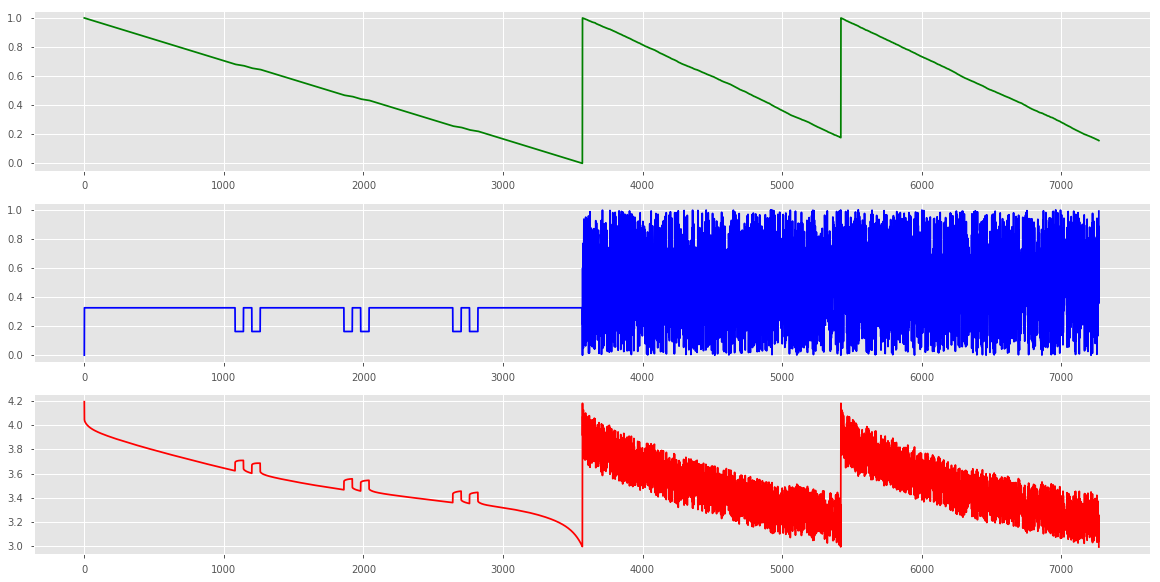

In [6]:
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
plt.figure("Characterisation_Set")
plt.subplot(311)
plt.plot(SoC, '-g')
plt.subplot(312)
plt.plot(Current, '-b')
plt.subplot(313)
plt.plot(Voltage, '-r')
plt.show()

## 2. Train RNN from Prior

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class RNN_Network(nn.Module):
    def __init__(self):
        super(RNN_Network, self).__init__()
        self.Z_hl1 = nn.Linear(2, 1024)
        self.Z_hl2 = nn.Linear(1024, 512)
        self.Z_p = nn.Linear(512, 1)
    
    def VoC(self, SoC):
        v_L = torch.Tensor([[-1.59614486]]).to(device)
        v_0 = torch.Tensor([[4.13646328]]).to(device)
        gamma = torch.Tensor([[0.63726463]]).to(device)
        alpha = torch.Tensor([[1.40174122]]).to(device)
        beta = torch.Tensor([[2.54478965]]).to(device)
        return v_L + (v_0 - v_L)*torch.exp(gamma*(SoC - 1)) + alpha*v_L*(SoC - 1) \
            + (1 - alpha)*v_L*(torch.exp(-beta) - torch.exp(-beta*torch.sqrt(SoC)))


    def forward(self, soc_init, current):
        
        voltage = torch.empty(current.shape, dtype=torch.float)
        soc_hist = torch.empty(current.shape, dtype=torch.float)
        soc = torch.Tensor([[soc_init]])
        soc = soc.to(device, torch.float)
        print(soc)
        
        for t in range(current.shape[1]):
            soc_in = soc
            I = torch.Tensor([[current[0, t]]])
            I = I.to(device, torch.float)
            # Estimate Z_p
            combined = torch.cat((soc_in, I), 1)
            Z = torch.sigmoid(self.Z_hl1(combined))
            Z = torch.sigmoid(self.Z_hl2(Z))
            Z = self.Z_p(Z)

            # Estimate V
            scaled_I = I*(Current_max - Current_min) + Current_min
            V = self.VoC(soc_in) - scaled_I*Z

            # Predict SoC
            soc = soc_in - scaled_I*V/Characterisation_Set['E_crit']
            
            print(soc)
            print(V)
            voltage[0, t] = V
            soc_hist[0, t] = soc
        
        return voltage, soc_hist

In [19]:
load_prior_network = "./Battery_Data/new_battery_cycles/Battery_RNN_prior_v1.mdl"
save_network = "./Battery_Data/new_battery_cycles/Battery_RNN_from_prior_v1.mdl"

In [20]:
rnn = RNN_Network()
rnn.load_state_dict(torch.load(load_prior_network))

In [21]:
rnn.to(device)

RNN_Network(
  (Z_hl1): Linear(in_features=2, out_features=1024, bias=True)
  (Z_hl2): Linear(in_features=1024, out_features=512, bias=True)
  (Z_p): Linear(in_features=512, out_features=1, bias=True)
)

tensor([[1.]], device='cuda:0')
tensor([[1.]], device='cuda:0')
tensor([[4.1365]], device='cuda:0')
tensor([[0.9982]], device='cuda:0')
tensor([[3.1503]], device='cuda:0')
tensor([[0.9964]], device='cuda:0')
tensor([[3.1477]], device='cuda:0')
tensor([[0.9947]], device='cuda:0')
tensor([[3.1450]], device='cuda:0')
tensor([[0.9929]], device='cuda:0')
tensor([[3.1424]], device='cuda:0')
tensor([[0.9911]], device='cuda:0')
tensor([[3.1398]], device='cuda:0')
tensor([[0.9894]], device='cuda:0')
tensor([[3.1372]], device='cuda:0')
tensor([[0.9876]], device='cuda:0')
tensor([[3.1347]], device='cuda:0')
tensor([[0.9858]], device='cuda:0')
tensor([[3.1321]], device='cuda:0')
tensor([[0.9841]], device='cuda:0')
tensor([[3.1295]], device='cuda:0')
tensor([[0.9823]], device='cuda:0')
tensor([[3.1270]], device='cuda:0')
tensor([[0.9805]], device='cuda:0')
tensor([[3.1244]], device='cuda:0')
tensor([[0.9788]], device='cuda:0')
tensor([[3.1219]], device='cuda:0')
tensor([[0.9770]], device='cuda:0')


tensor([[0.6918]], device='cuda:0')
tensor([[2.7921]], device='cuda:0')
tensor([[0.6902]], device='cuda:0')
tensor([[2.7907]], device='cuda:0')
tensor([[0.6886]], device='cuda:0')
tensor([[2.7893]], device='cuda:0')
tensor([[0.6871]], device='cuda:0')
tensor([[2.7879]], device='cuda:0')
tensor([[0.6855]], device='cuda:0')
tensor([[2.7865]], device='cuda:0')
tensor([[0.6839]], device='cuda:0')
tensor([[2.7852]], device='cuda:0')
tensor([[0.6823]], device='cuda:0')
tensor([[2.7838]], device='cuda:0')
tensor([[0.6808]], device='cuda:0')
tensor([[2.7824]], device='cuda:0')
tensor([[0.6792]], device='cuda:0')
tensor([[2.7811]], device='cuda:0')
tensor([[0.6776]], device='cuda:0')
tensor([[2.7797]], device='cuda:0')
tensor([[0.6761]], device='cuda:0')
tensor([[2.7784]], device='cuda:0')
tensor([[0.6745]], device='cuda:0')
tensor([[2.7770]], device='cuda:0')
tensor([[0.6729]], device='cuda:0')
tensor([[2.7757]], device='cuda:0')
tensor([[0.6714]], device='cuda:0')
tensor([[2.7744]], device='c

tensor([[0.3909]], device='cuda:0')
tensor([[2.5894]], device='cuda:0')
tensor([[0.3894]], device='cuda:0')
tensor([[2.5886]], device='cuda:0')
tensor([[0.3880]], device='cuda:0')
tensor([[2.5879]], device='cuda:0')
tensor([[0.3865]], device='cuda:0')
tensor([[2.5872]], device='cuda:0')
tensor([[0.3851]], device='cuda:0')
tensor([[2.5864]], device='cuda:0')
tensor([[0.3836]], device='cuda:0')
tensor([[2.5857]], device='cuda:0')
tensor([[0.3821]], device='cuda:0')
tensor([[2.5850]], device='cuda:0')
tensor([[0.3807]], device='cuda:0')
tensor([[2.5842]], device='cuda:0')
tensor([[0.3792]], device='cuda:0')
tensor([[2.5835]], device='cuda:0')
tensor([[0.3778]], device='cuda:0')
tensor([[2.5828]], device='cuda:0')
tensor([[0.3763]], device='cuda:0')
tensor([[2.5820]], device='cuda:0')
tensor([[0.3749]], device='cuda:0')
tensor([[2.5813]], device='cuda:0')
tensor([[0.3734]], device='cuda:0')
tensor([[2.5806]], device='cuda:0')
tensor([[0.3719]], device='cuda:0')
tensor([[2.5799]], device='c

tensor([[0.1111]], device='cuda:0')
tensor([[2.3924]], device='cuda:0')
tensor([[0.1098]], device='cuda:0')
tensor([[2.3912]], device='cuda:0')
tensor([[0.1084]], device='cuda:0')
tensor([[2.3899]], device='cuda:0')
tensor([[0.1071]], device='cuda:0')
tensor([[2.3887]], device='cuda:0')
tensor([[0.1057]], device='cuda:0')
tensor([[2.3874]], device='cuda:0')
tensor([[0.1044]], device='cuda:0')
tensor([[2.3861]], device='cuda:0')
tensor([[0.1030]], device='cuda:0')
tensor([[2.3849]], device='cuda:0')
tensor([[0.1017]], device='cuda:0')
tensor([[2.3836]], device='cuda:0')
tensor([[0.1003]], device='cuda:0')
tensor([[2.3823]], device='cuda:0')
tensor([[0.0990]], device='cuda:0')
tensor([[2.3809]], device='cuda:0')
tensor([[0.0977]], device='cuda:0')
tensor([[2.3796]], device='cuda:0')
tensor([[0.0963]], device='cuda:0')
tensor([[2.3783]], device='cuda:0')
tensor([[0.0950]], device='cuda:0')
tensor([[2.3769]], device='cuda:0')
tensor([[0.0936]], device='cuda:0')
tensor([[2.3755]], device='c

tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[n

tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[n

tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[n

tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[n

tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[n

tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[n

tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[n

tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[n

tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[n

tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[n

tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[n

tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[n

tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[n

tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[n

tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[n

tensor([[0.8380]], device='cuda:0')
tensor([[1.1735]], device='cuda:0')
tensor([[0.8360]], device='cuda:0')
tensor([[1.3412]], device='cuda:0')
tensor([[0.8344]], device='cuda:0')
tensor([[2.9922]], device='cuda:0')
tensor([[0.8335]], device='cuda:0')
tensor([[3.4551]], device='cuda:0')
tensor([[0.8314]], device='cuda:0')
tensor([[1.6974]], device='cuda:0')
tensor([[0.8293]], device='cuda:0')
tensor([[2.4376]], device='cuda:0')
tensor([[0.8276]], device='cuda:0')
tensor([[2.8829]], device='cuda:0')
tensor([[0.8263]], device='cuda:0')
tensor([[3.2472]], device='cuda:0')
tensor([[0.8257]], device='cuda:0')
tensor([[3.5953]], device='cuda:0')
tensor([[0.8236]], device='cuda:0')
tensor([[2.4294]], device='cuda:0')
tensor([[0.8215]], device='cuda:0')
tensor([[1.6455]], device='cuda:0')
tensor([[0.8198]], device='cuda:0')
tensor([[2.9042]], device='cuda:0')
tensor([[0.8178]], device='cuda:0')
tensor([[2.4064]], device='cuda:0')
tensor([[0.8156]], device='cuda:0')
tensor([[1.9107]], device='c

tensor([[0.5688]], device='cuda:0')
tensor([[3.2115]], device='cuda:0')
tensor([[0.5672]], device='cuda:0')
tensor([[1.1455]], device='cuda:0')
tensor([[0.5653]], device='cuda:0')
tensor([[1.7283]], device='cuda:0')
tensor([[0.5634]], device='cuda:0')
tensor([[1.5396]], device='cuda:0')
tensor([[0.5618]], device='cuda:0')
tensor([[2.6184]], device='cuda:0')
tensor([[0.5610]], device='cuda:0')
tensor([[3.2631]], device='cuda:0')
tensor([[0.5592]], device='cuda:0')
tensor([[1.4476]], device='cuda:0')
tensor([[0.5578]], device='cuda:0')
tensor([[0.9097]], device='cuda:0')
tensor([[0.5567]], device='cuda:0')
tensor([[0.6521]], device='cuda:0')
tensor([[0.5548]], device='cuda:0')
tensor([[1.5667]], device='cuda:0')
tensor([[0.5529]], device='cuda:0')
tensor([[2.1774]], device='cuda:0')
tensor([[0.5525]], device='cuda:0')
tensor([[3.4333]], device='cuda:0')
tensor([[0.5507]], device='cuda:0')
tensor([[1.4256]], device='cuda:0')
tensor([[0.5489]], device='cuda:0')
tensor([[2.3833]], device='c

tensor([[0.3270]], device='cuda:0')
tensor([[2.1829]], device='cuda:0')
tensor([[0.3255]], device='cuda:0')
tensor([[2.5780]], device='cuda:0')
tensor([[0.3240]], device='cuda:0')
tensor([[2.4623]], device='cuda:0')
tensor([[0.3224]], device='cuda:0')
tensor([[1.1821]], device='cuda:0')
tensor([[0.3210]], device='cuda:0')
tensor([[2.5036]], device='cuda:0')
tensor([[0.3192]], device='cuda:0')
tensor([[1.6265]], device='cuda:0')
tensor([[0.3191]], device='cuda:0')
tensor([[3.5162]], device='cuda:0')
tensor([[0.3174]], device='cuda:0')
tensor([[1.6438]], device='cuda:0')
tensor([[0.3172]], device='cuda:0')
tensor([[3.4562]], device='cuda:0')
tensor([[0.3157]], device='cuda:0')
tensor([[1.0678]], device='cuda:0')
tensor([[0.3147]], device='cuda:0')
tensor([[2.9185]], device='cuda:0')
tensor([[0.3130]], device='cuda:0')
tensor([[2.2702]], device='cuda:0')
tensor([[0.3117]], device='cuda:0')
tensor([[0.9310]], device='cuda:0')
tensor([[0.3116]], device='cuda:0')
tensor([[3.5318]], device='c

tensor([[1.7230]], device='cuda:0')
tensor([[0.1036]], device='cuda:0')
tensor([[1.6321]], device='cuda:0')
tensor([[0.1024]], device='cuda:0')
tensor([[2.5403]], device='cuda:0')
tensor([[0.1008]], device='cuda:0')
tensor([[1.8266]], device='cuda:0')
tensor([[0.0997]], device='cuda:0')
tensor([[2.6779]], device='cuda:0')
tensor([[0.0989]], device='cuda:0')
tensor([[0.4946]], device='cuda:0')
tensor([[0.0982]], device='cuda:0')
tensor([[0.4263]], device='cuda:0')
tensor([[0.0973]], device='cuda:0')
tensor([[2.7874]], device='cuda:0')
tensor([[0.0958]], device='cuda:0')
tensor([[2.1698]], device='cuda:0')
tensor([[0.0943]], device='cuda:0')
tensor([[1.1884]], device='cuda:0')
tensor([[0.0938]], device='cuda:0')
tensor([[3.1188]], device='cuda:0')
tensor([[0.0924]], device='cuda:0')
tensor([[1.1334]], device='cuda:0')
tensor([[0.0910]], device='cuda:0')
tensor([[2.2269]], device='cuda:0')
tensor([[0.0899]], device='cuda:0')
tensor([[2.6867]], device='cuda:0')
tensor([[0.0884]], device='c

tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[n

tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[n

tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[n

tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[n

tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[n

tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[n

tensor([[0.9346]], device='cuda:0')
tensor([[1.0554]], device='cuda:0')
tensor([[0.9323]], device='cuda:0')
tensor([[1.6553]], device='cuda:0')
tensor([[0.9307]], device='cuda:0')
tensor([[3.1878]], device='cuda:0')
tensor([[0.9284]], device='cuda:0')
tensor([[1.9328]], device='cuda:0')
tensor([[0.9263]], device='cuda:0')
tensor([[2.6454]], device='cuda:0')
tensor([[0.9240]], device='cuda:0')
tensor([[1.6898]], device='cuda:0')
tensor([[0.9220]], device='cuda:0')
tensor([[2.7753]], device='cuda:0')
tensor([[0.9211]], device='cuda:0')
tensor([[3.5658]], device='cuda:0')
tensor([[0.9197]], device='cuda:0')
tensor([[3.2562]], device='cuda:0')
tensor([[0.9178]], device='cuda:0')
tensor([[1.1114]], device='cuda:0')
tensor([[0.9165]], device='cuda:0')
tensor([[3.3260]], device='cuda:0')
tensor([[0.9152]], device='cuda:0')
tensor([[3.3722]], device='cuda:0')
tensor([[0.9130]], device='cuda:0')
tensor([[2.2833]], device='cuda:0')
tensor([[0.9129]], device='cuda:0')
tensor([[3.9883]], device='c

tensor([[0.6275]], device='cuda:0')
tensor([[2.3778]], device='cuda:0')
tensor([[0.6266]], device='cuda:0')
tensor([[3.2431]], device='cuda:0')
tensor([[0.6251]], device='cuda:0')
tensor([[2.8136]], device='cuda:0')
tensor([[0.6232]], device='cuda:0')
tensor([[1.9117]], device='cuda:0')
tensor([[0.6213]], device='cuda:0')
tensor([[1.4683]], device='cuda:0')
tensor([[0.6202]], device='cuda:0')
tensor([[3.1326]], device='cuda:0')
tensor([[0.6194]], device='cuda:0')
tensor([[3.2542]], device='cuda:0')
tensor([[0.6179]], device='cuda:0')
tensor([[0.9550]], device='cuda:0')
tensor([[0.6159]], device='cuda:0')
tensor([[1.8329]], device='cuda:0')
tensor([[0.6145]], device='cuda:0')
tensor([[2.8880]], device='cuda:0')
tensor([[0.6126]], device='cuda:0')
tensor([[1.7914]], device='cuda:0')
tensor([[0.6125]], device='cuda:0')
tensor([[3.7026]], device='cuda:0')
tensor([[0.6108]], device='cuda:0')
tensor([[1.2255]], device='cuda:0')
tensor([[0.6088]], device='cuda:0')
tensor([[1.8809]], device='c

tensor([[0.3748]], device='cuda:0')
tensor([[1.2912]], device='cuda:0')
tensor([[0.3731]], device='cuda:0')
tensor([[2.0225]], device='cuda:0')
tensor([[0.3713]], device='cuda:0')
tensor([[1.6984]], device='cuda:0')
tensor([[0.3695]], device='cuda:0')
tensor([[1.7680]], device='cuda:0')
tensor([[0.3684]], device='cuda:0')
tensor([[0.6759]], device='cuda:0')
tensor([[0.3669]], device='cuda:0')
tensor([[2.5217]], device='cuda:0')
tensor([[0.3651]], device='cuda:0')
tensor([[1.6794]], device='cuda:0')
tensor([[0.3633]], device='cuda:0')
tensor([[1.5061]], device='cuda:0')
tensor([[0.3628]], device='cuda:0')
tensor([[3.2959]], device='cuda:0')
tensor([[0.3611]], device='cuda:0')
tensor([[1.8298]], device='cuda:0')
tensor([[0.3601]], device='cuda:0')
tensor([[0.5507]], device='cuda:0')
tensor([[0.3588]], device='cuda:0')
tensor([[0.8778]], device='cuda:0')
tensor([[0.3572]], device='cuda:0')
tensor([[2.3556]], device='cuda:0')
tensor([[0.3554]], device='cuda:0')
tensor([[2.1000]], device='c

tensor([[0.1265]], device='cuda:0')
tensor([[1.4447]], device='cuda:0')
tensor([[0.1250]], device='cuda:0')
tensor([[1.3314]], device='cuda:0')
tensor([[0.1238]], device='cuda:0')
tensor([[0.8428]], device='cuda:0')
tensor([[0.1232]], device='cuda:0')
tensor([[3.1165]], device='cuda:0')
tensor([[0.1217]], device='cuda:0')
tensor([[2.1653]], device='cuda:0')
tensor([[0.1210]], device='cuda:0')
tensor([[0.4429]], device='cuda:0')
tensor([[0.1194]], device='cuda:0')
tensor([[1.4817]], device='cuda:0')
tensor([[0.1180]], device='cuda:0')
tensor([[1.0580]], device='cuda:0')
tensor([[0.1173]], device='cuda:0')
tensor([[2.9681]], device='cuda:0')
tensor([[0.1160]], device='cuda:0')
tensor([[2.4749]], device='cuda:0')
tensor([[0.1144]], device='cuda:0')
tensor([[1.3685]], device='cuda:0')
tensor([[0.1141]], device='cuda:0')
tensor([[3.2453]], device='cuda:0')
tensor([[0.1139]], device='cuda:0')
tensor([[3.3335]], device='cuda:0')
tensor([[0.1131]], device='cuda:0')
tensor([[0.5045]], device='c

tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[n

tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[n

tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[n

tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[n

tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[n

tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[nan]], device='cuda:0')
tensor([[n

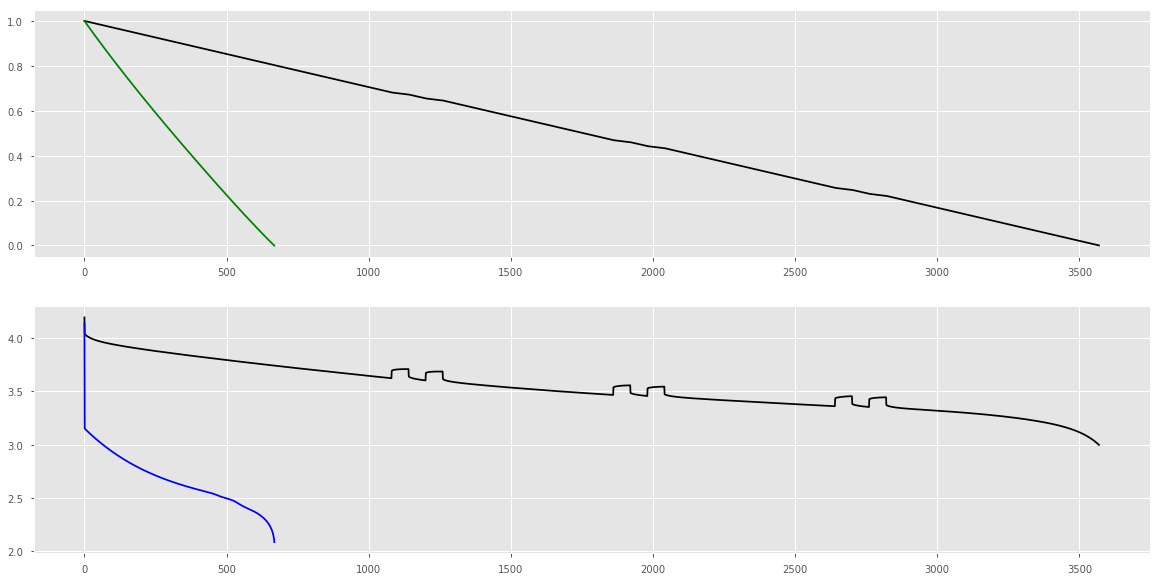

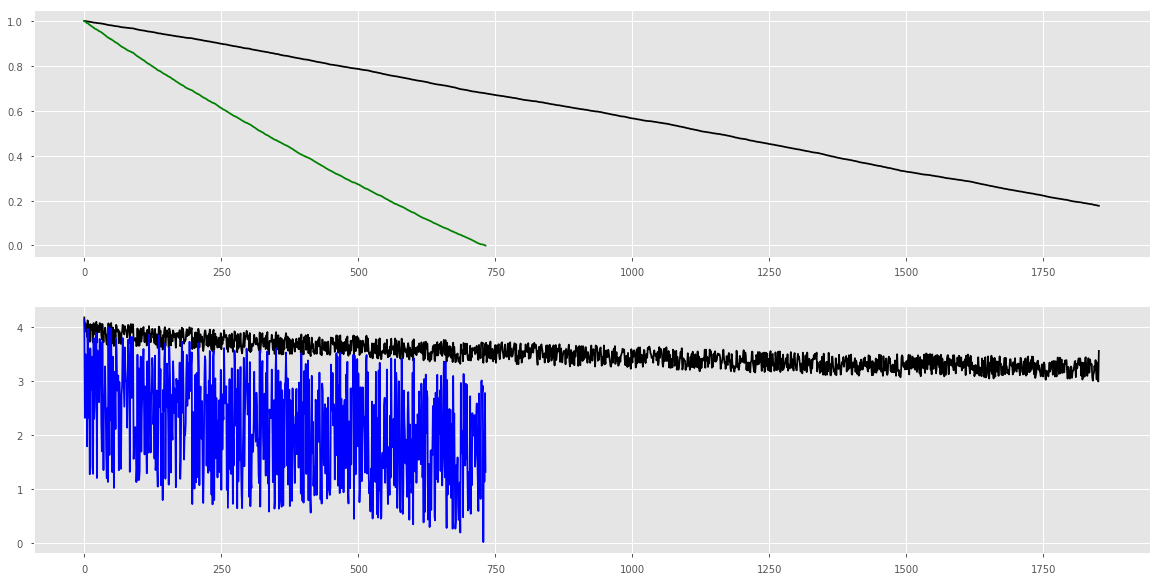

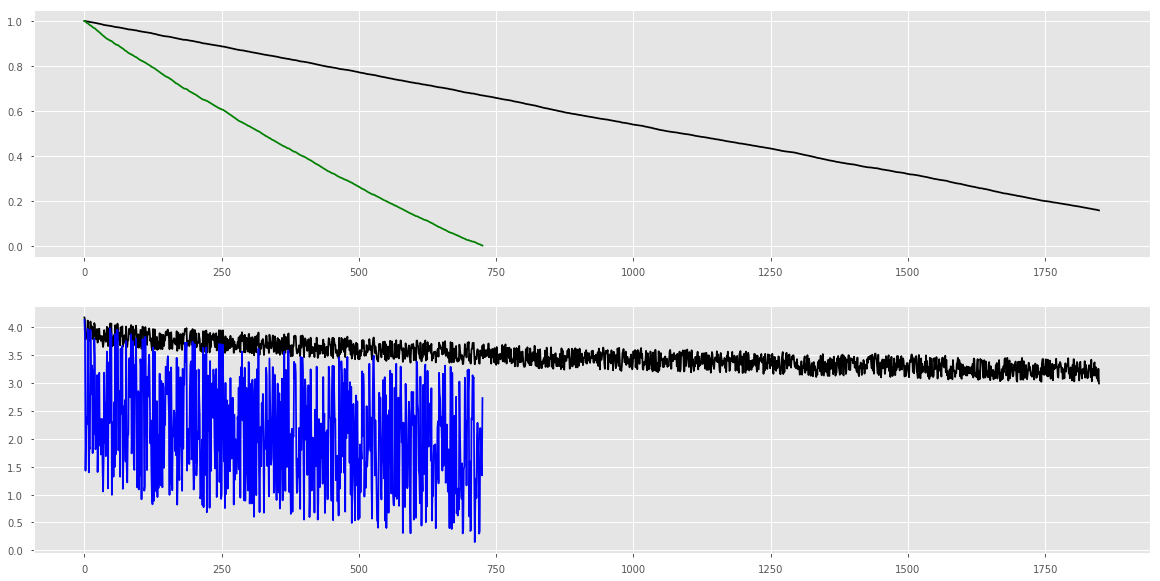

In [22]:
with torch.no_grad():
    for i, set_dict in enumerate(Characterisation_Set['Sets']):
        
        V = torch.from_numpy(set_dict['Voltage']).float()
        V_est, SoC = rnn(set_dict['SoC'][0, 0], set_dict['Current'])
        print(SoC, V_est)
        plt.figure(i)
        plt.subplot(2,1,1)
        plt.plot(set_dict['SoC'].T, 'k')
        plt.plot(SoC.to("cpu").numpy().T, 'g')
        plt.subplot(2,1,2)
        plt.plot(V.to("cpu").numpy().T, 'k')
        plt.plot(V_est.to("cpu").numpy().T, 'b')

In [11]:
# Loss and optimizer
criterion = nn.MSELoss()# Mean Squared Loss
# The weight_decay option implements L2 regularisation
optimizer = optim.Adam(rnn.parameters()) 

tensor([[nan, nan, nan,  ..., nan, nan, nan]], grad_fn=<CopySlices>)
tensor([[nan, nan, nan,  ..., nan, nan, nan]], grad_fn=<CopySlices>)


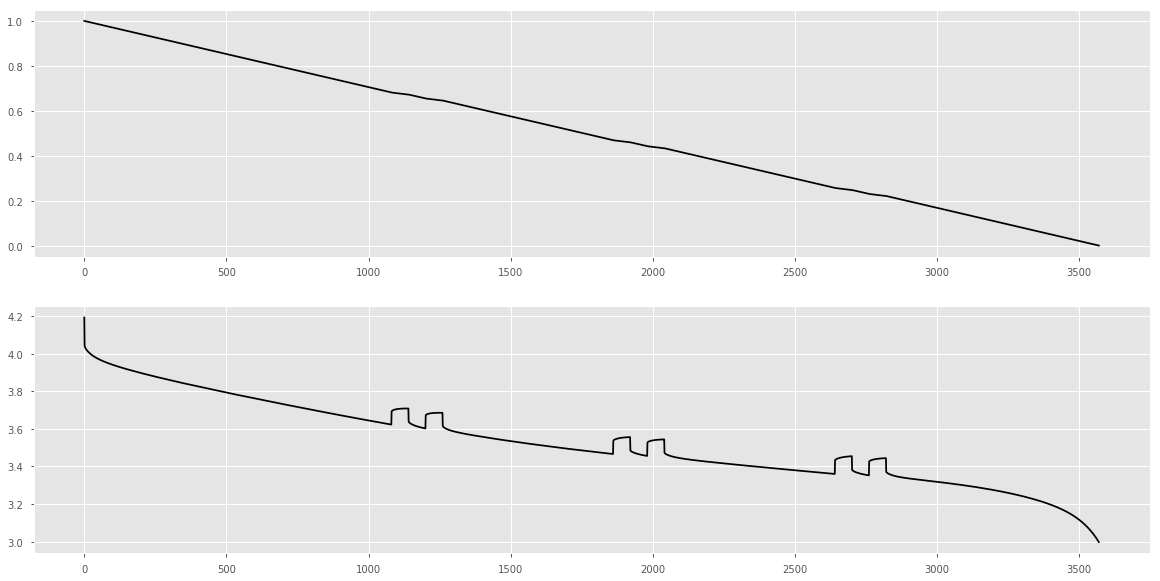

tensor([[nan, nan, nan,  ..., nan, nan, nan]], grad_fn=<CopySlices>)
tensor([[nan, nan, nan,  ..., nan, nan, nan]], grad_fn=<CopySlices>)


KeyboardInterrupt: 

In [14]:
import time
import math

epochs = 5000
running_loss = 0.0
loss_min = 1e10
loss_hist = []
    
rnn.train()
start = time.time()

def timeSince(since):
    now = time.time()
    interval = now - since
    m = math.floor(interval / 60)
    s = interval - m * 60
    return '%dm %ds' % (m, s), now, interval

for epoch in range(epochs):
    count = -1
    avg_loss = 0
    loss_set_hist = []
    
    for set_dict in Characterisation_Set['Sets']:
        count += 1
        V = torch.from_numpy(set_dict['Voltage']).float()
        optimizer.zero_grad()
        V_est, SoC = rnn(set_dict['SoC'][0, 0], set_dict['Current'])
        print(V_est)
        print(SoC)
        loss = criterion(V_est, V)
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
        loss_set_hist.append(loss.item())
        if epoch == 0:
            with torch.no_grad():
                V_est, SoC = rnn(set_dict['SoC'][0, 0], set_dict['Current'])
                plt.figure(count)
                plt.subplot(2,1,1)
                plt.plot(set_dict['SoC'].T, 'k')
                plt.plot(SoC.to("cpu").numpy().T, 'g')
                plt.subplot(2,1,2)
                plt.plot(V.to("cpu").numpy().T, 'k')
                plt.plot(V_est.to("cpu").numpy().T, 'b')
                plt.show()
    loss_hist.append(loss_set_hist)
    avg_loss /= (count+1)
        
    if epoch % 5 == 0:
        now_string, now, interval = timeSince(start)
        remaining_epochs = epochs-(epoch+1)
        remaining_time = interval*remaining_epochs/(epoch + 1)
        h_f = remaining_time / 60.0 / 60.0
        h = math.floor(h_f)
        m_f = (h_f - h)*60.0
        m = math.floor(m_f)
        s = (m_f - m)*60.0
        remaining_string = '%dh %dm %ds' % (h, m, s)
        print("epoch {}, time since start: {}, estimated remaining time: {}".format(epoch, now_string, remaining_string))
    if avg_loss < loss_min:
        print("New average minimum: ", avg_loss)
        torch.save(battery.state_dict(), save_network)
        loss_min = avg_loss